For Part IV of this project I will create some synthetic data that follows a geometric brownian motion process, for each stock in the market portfolio. I will then apply my entropy signal to this and fit for the QED model.

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.stats import entropy

import matplotlib.pyplot as plt
from datetime import datetime

In [0]:
#####Part 4 - Testing out signals on random data that follows a stochastic brownian motion process
np.random.seed(42)
Z = np.random.normal(0, 1, size=(2080,30)).T
sVals = np.zeros((30, 2080), 'float')  # matrix of stock values
sVals[:,0] = 100.0 *np.ones(30, 'float')
vol = np.random.rand(30)/100.0
test_mu = np.random.rand(30)/100.0
dt = 0.01

for i in (np.arange(2079)):
    for j in np.arange(30):
        sVals[j,i+1] = sVals[j,i]*np.exp(((test_mu[j] - (0.5 * (vol[j] ** 2)))*dt)+(vol[j]*np.sqrt(dt)*Z[j,i+1]))
print(sVals.T.shape)
print(np.random.randint(low=0, high=1000, size=(2080, 30)).shape)

browmnian_data = pd.DataFrame(sVals.T, columns=['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DWDP', 'GE', 'GS',
       'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT',
       'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM'])
browmnian_data = np.log(browmnian_data)
browmnian_data = ((browmnian_data/np.mean(browmnian_data.iloc[0]))) #renormalise the market caps to all start with a number close to 1

# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=browmnian_data.shape[0], freq='B')
browmnian_data['date'] = dates

browmnian_data.set_index('date',inplace=True) 
browmnian_data.head()

(2080, 30)
(2080, 30)


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-01-05,0.999923,1.000149,1.000018,0.999827,1.000078,0.999957,1.000023,0.999618,0.999964,1.000023,...,1.000037,0.999976,0.999871,1.000040,1.000161,1.000105,0.999868,0.999972,1.000018,1.000194
2010-01-06,0.999865,1.000147,1.000002,0.999628,1.000154,1.000021,1.000037,0.999829,0.999976,0.999980,...,1.000034,1.000027,1.000185,1.000009,1.000062,1.000058,1.000015,1.000009,1.000006,1.000301
2010-01-07,0.999895,1.000230,0.999998,0.999589,1.000130,0.999968,1.000063,0.999891,0.999978,0.999970,...,0.999909,1.000040,1.000208,1.000164,1.000050,1.000096,1.000011,0.999893,1.000052,1.000452
2010-01-08,1.000029,1.000174,1.000059,0.999352,1.000188,1.000066,1.000048,0.999787,0.999983,0.999938,...,0.999939,1.000186,0.999888,1.000178,1.000102,1.000184,0.999816,0.999761,1.000076,1.000518


In [0]:
prices = np.array(browmnian_data).astype(float)
updown = np.zeros((2080, 30), 'float')  # matrix of stock values
entropy_updown = np.zeros((2080, 30), 'float') 

for row in range(1,browmnian_data.shape[0]):
    for column in range(browmnian_data.shape[1]):
        if (prices[row, column] > prices[row - 1, column]):
            updown[row, column] = +1
        else:
            updown[row, column] = -1

entropy_time_lag = 10
for row in range(entropy_time_lag,browmnian_data.shape[0]):
    for column in range(browmnian_data.shape[1]):
        unique, counts = np.unique(updown[row-entropy_time_lag:row, column], return_counts=True)
        entropy_updown[row, column] = entropy(counts/np.sum(counts))


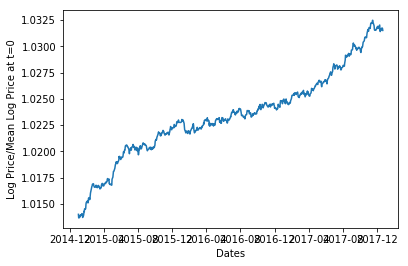

In [0]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

plt.plot(browmnian_data.loc[start_date:end_date, :].index, browmnian_data.loc[start_date:end_date, 'AAPL'], label='Cap')
plt.ylabel('Log Price/Mean Log Price at t=0')
plt.xlabel('Dates')
plt.show()

I will use tensorflow and set up a graph to minimise the negative log likelihood as given in the ipython notebook. 

I optmise for thirty-four (34) parameters, with the following initial parameters:
- The theta value (0.0)
- The sigma value (1.0)
- The kappa value (0.0)
- The g value (0.0)
- The weights vector with thirty free parameters [0.0]x30

I also use the Adam Gradient Descent optmisation algorithm as this has a variable lerning rate which is applicable and useful in such a high dimensional space. 

I also normalise the data by first switching the raw data into log space, and then normalising by the initial mean market cap at time 0. This ensure that the model can converge efficiently and accurately. It improves model performace and is a tractable space transformation.

In [0]:
####Part 1
####Declaring Hyperparamters
learning_rate = 0.01
training_epochs = 50
training_steps = 38 
batch_length = 50
first_index = 100

####Declaring raw log data (i.e all timeseries start at 100)
times_data = np.arange(browmnian_data.shape[0]-1).astype(int)
stock_prices_data = np.array(browmnian_data).astype(float)
signals_data = np.array(entropy_updown).astype(float)

####Declaring constant placeholders
times = tf.placeholder(tf.int32, shape=[None])  #times = tf.constant(np.arange(int(stock_prices_data.shape[0])), dtype = tf.int32)
stock_prices = tf.placeholder(tf.float32, shape=[None, None])  #stock_prices = tf.constant(np.array(browmnian_data), dtype = tf.float32)
signals = tf.placeholder(tf.float32, shape=[None, None])  #signals = tf.constant(np.array(entropy_updown), dtype = tf.float32)

####Declaring variable placeholders
theta = tf.Variable(initial_value=0.0, dtype=tf.float32)
sigma = tf.Variable(initial_value=1.0, dtype=tf.float32)
kappa = tf.Variable(initial_value=0.0, dtype=tf.float32)
little_g = tf.Variable(initial_value=0.0, dtype=tf.float32)   
weights_vector = tf.Variable(initial_value=0.0*tf.ones(browmnian_data.shape[1], dtype=tf.float32), dtype=tf.float32)

####Declaring Lambda functions
def delta_V_over_delta_y_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices):
    """
    delta_V_over_delta_y_t - compute the partial derivative of V with respect to y that is used in the minimum likelihood equation.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    Return:
    delta_V_over_delta_y_t_function - a lambda function which returns the partial derivative vector at a given time index
    """
    delta_V_over_delta_y_t_function = lambda index:  (((tf.pow(sigma, 2)/2.0) - theta -  (tf.tensordot( weights_vector,tf.squeeze(tf.gather(signals, [index])),1)))*tf.ones(30, dtype=tf.float32)  ) + (kappa*tf.exp(tf.squeeze(tf.gather(stock_prices, [index])))) + (little_g*tf.exp(2.0*tf.squeeze(tf.gather(stock_prices, [index]))))
    return delta_V_over_delta_y_t_function 

def neg_log_likelihood_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices):
    """
    neg_log_likelihood_t - compute the negative log likelihood scalar that is minimised in the optimisation.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    Return:
    neg_log_likelihood_t_function - a lambda function which returns the log_likelihood scalar function at a given time index
    """ 
    delta_V_over_delta_y_time = delta_V_over_delta_y_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices)
    ####ignore 2pi term as it is a constant and does blow up 
    neg_log_likelihood_t_function = lambda index: tf.log(tf.abs(sigma)) + ( (1.0/(2.0*sigma*sigma)) * ((tf.norm(((((tf.squeeze(tf.gather(stock_prices, [index+1])) - tf.squeeze(tf.gather(stock_prices, [index]))))   ) ) + delta_V_over_delta_y_time(index)))**2))
    return neg_log_likelihood_t_function

def log_likelihood(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices, times):
    """
    log_likelihood - compute the summed negative log likelihood scalar that is the sum over times of neg_log_likelihood_t.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    times - a tensorflow object that represents the vector of indices for which we sum across
    Return:
    LL_theta_t_map_result_remove_nans - a scalar of the negative log likelihood function across indices in times
    """ 
    LL_theta_t = neg_log_likelihood_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices)
    LL_theta_t_map_result = tf.map_fn(LL_theta_t, times, dtype=tf.float32)
    LL_theta_t_map_result_remove_nans = tf.where(tf.is_nan(LL_theta_t_map_result), tf.zeros_like(LL_theta_t_map_result), LL_theta_t_map_result)
    return LL_theta_t_map_result_remove_nans
    
####Creating the log sum and creating the error term
LL_theta_t_map_result_remove_nans = log_likelihood(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices, times)
error = tf.reduce_sum(LL_theta_t_map_result_remove_nans, 0)

####Gradient of the log likelihood
grad = tf.gradients(error, [theta, sigma, kappa, little_g])
grad_weights = tf.gradients(error, [weights_vector])

####The Adam Gradient Descent Optimizer does the heavy lifting
train_op = tf.train.AdamOptimizer(learning_rate).minimize(error)

####Normal TensorFlow - initialize values, create a session and run the model
model = tf.global_variables_initializer()

####Summaries
tf.summary.scalar("loss",error)
merged_summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(model)
        
    print("starting at", "theta:", sess.run(theta))
    print("starting at", "sigma:", sess.run(sigma))
    print("starting at", "kappa:", sess.run(kappa))
    print("starting at", "g:", sess.run(little_g))
    print("starting at", "weights:", sess.run(weights_vector)) 

    obs_theta, obs_sigma, obs_kappa, obs_little_g, obs_weights_vector = sess.run(fetches=[theta, sigma, kappa, little_g, weights_vector])
    
    errors = np.array([1])
    gradients = np.empty(shape=[4])
    gradients_weights = np.empty(shape=[30])

    for epoch in range(training_epochs):
        for step in range(training_steps):
            stock_prices_data = np.array(browmnian_data).astype(float)
            signals_data = np.array(entropy_updown).astype(float)
            starting_index = first_index + step*batch_length
            times_data = np.arange(browmnian_data.shape[0]-1).astype(int)[starting_index:starting_index+batch_length]
            print(epoch, starting_index, starting_index+batch_length)
            op, numerical_error, summary = sess.run([train_op, error, merged_summary_op], feed_dict={stock_prices: stock_prices_data, signals: signals_data, times: times_data})
            print("numerical_error:", numerical_error)
            
            new_obs_theta, new_obs_sigma, new_obs_kappa, new_obs_little_g, new_obs_weights_vector = sess.run(fetches=[theta, sigma, kappa, little_g, weights_vector])
            numerical_error = sess.run(fetches=error, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data})
            new_gradients = sess.run(fetches=grad, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data})
            new_gradients_weights = sess.run(fetches=grad_weights, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data})
            
            errors = np.append(errors, numerical_error)
            obs_theta = np.append(obs_theta, new_obs_theta)
            obs_sigma = np.append(obs_sigma, new_obs_sigma)
            obs_kappa = np.append(obs_kappa, new_obs_kappa)
            obs_little_g = np.append(obs_little_g, new_obs_little_g)
            obs_weights_vector = np.vstack([obs_weights_vector, new_obs_weights_vector])
            gradients = np.vstack([gradients,new_gradients])
            gradients_weights = np.vstack([gradients_weights,new_gradients_weights])
            print(new_obs_theta, new_obs_sigma, new_obs_kappa, new_obs_little_g, new_obs_weights_vector[0])
            
    print("ending at", "theta:", sess.run(theta))
    print("ending at", "sigma:", sess.run(sigma))
    print("ending at", "kappa:", sess.run(kappa))
    print("ending at", "g:", sess.run(little_g))
    print("ending at", "weights:", sess.run(weights_vector))      
    print("ending at", "error:", sess.run(error, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data}))
    
    sess.close()



starting at theta: 0.0
starting at sigma: 1.0
starting at kappa: 0.0
starting at g: 0.0
starting at weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
0 100 150
numerical_error: 187.50342
0.01 0.99 -0.010000001 -0.009999999 0.009999998
0 150 200
numerical_error: 26.538288
0.018921595 0.9803075 -0.018922083 -0.018922567 0.018871093
0 200 250
numerical_error: 6.015763
0.024549747 0.97430295 -0.024549592 -0.02454943 0.024436338
0 250 300
numerical_error: 51.13813
0.026083555 0.9744069 -0.026079196 -0.026074827 0.025974534
0 300 350
numerical_error: 77.094345
0.02460635 0.978037 -0.02459507 -0.02458377 0.024453908
0 350 400
numerical_error: 53.929893
0.021484114 0.98320675 -0.02146481 -0.021445476 0.021230992
0 400 450
numerical_error: 17.46368
0.01776259 0.9886868 -0.017734703 -0.017706772 0.017441265
0 450 500
numerical_error: 1.0903996
0.01419097 0.9936139 -0.014154784 -0.014118543 0.013813682
0 500 550
numerical_error: 3.0305438
0.0114

numerical_error: -8.628218
0.012250814 0.8348118 -0.012055882 -0.011857927 0.009576879
2 450 500
numerical_error: -8.932269
0.0123049915 0.83088714 -0.012109445 -0.011910856 0.009618574
2 500 550
numerical_error: -9.1753845
0.012275858 0.8269943 -0.012079638 -0.01188036 0.009576515
2 550 600
numerical_error: -9.4000025
0.012161732 0.82313406 -0.011964717 -0.011764632 0.009444953
2 600 650
numerical_error: -9.611731
0.011929476 0.81933314 -0.0117314225 -0.01153029 0.009196059
2 650 700
numerical_error: -9.883011
0.011609118 0.8155654 -0.011409781 -0.01120736 0.0088555515
2 700 750
numerical_error: -10.164064
0.011346365 0.81171167 -0.011145857 -0.010942261 0.00857411
2 750 800
numerical_error: -10.357429
0.011212113 0.8077163 -0.011010795 -0.010806381 0.008424519
2 800 850
numerical_error: -10.620305
0.011168876 0.80360955 -0.010967013 -0.010762049 0.008363274
2 850 900
numerical_error: -10.8885565
0.011201028 0.7994039 -0.010998883 -0.01079363 0.008379211
2 900 950
numerical_error: -11

numerical_error: -51.863476
0.003762086 0.34354624 -0.0033422164 -0.0029151058 -0.0002889205
4 750 800
numerical_error: -53.35046
0.0038114735 0.33349392 -0.0033896586 -0.0029605653 -0.00023364439
4 800 850
numerical_error: -54.8831
0.0036755747 0.32327414 -0.003251108 -0.0028193283 -0.00035801722
4 850 900
numerical_error: -56.45522
0.003477668 0.3128401 -0.0030502377 -0.0026154604 -0.0005457207
4 900 950
numerical_error: -58.003807
0.0038066546 0.3020392 -0.0033787084 -0.0029433903 -0.00021550554
4 950 1000
numerical_error: -59.076504
0.0025771025 0.2913922 -0.0021406163 -0.0016966996 -0.0014591187
4 1000 1050
numerical_error: -56.024315
0.005570023 0.2797847 -0.0051470567 -0.0047166967 0.0015674252
4 1050 1100
numerical_error: -18.501394
-0.0011432995 0.27380097 0.0015880396 0.0020401315 -0.005211662
4 1100 1150
numerical_error: 116.17096
0.0056375745 0.27158663 -0.0052010054 -0.004757031 0.0012789695
4 1150 1200
numerical_error: -16.699755
0.0063203336 0.27366066 -0.005883332 -0.00

numerical_error: -45.641865
0.004397422 0.3859293 -0.00399661 -0.003586089 -0.0051930887
6 950 1000
numerical_error: -37.636097
0.00420718 0.38751924 -0.0038148148 -0.0034127291 -0.005417521
6 1000 1050
numerical_error: -33.73724
0.0044718455 0.3886669 -0.004084979 -0.0036883694 -0.005166923
6 1050 1100
numerical_error: -38.311188
0.005062991 0.389431 -0.0046795313 -0.0042862985 -0.0045726593
6 1100 1150
numerical_error: -45.364864
0.005748353 0.38991073 -0.005367352 -0.0049765464 -0.003886567
6 1150 1200
numerical_error: -46.654976
0.0064185113 0.39017737 -0.0060395002 -0.005650655 -0.003215151
6 1200 1250
numerical_error: -45.870556
0.006900661 0.39034513 -0.0065237773 -0.0061370367 -0.0027354094
6 1250 1300
numerical_error: -42.363205
0.0070826802 0.39051023 -0.006708375 -0.0063242 -0.002562164
6 1300 1350
numerical_error: -38.545086
0.0069019385 0.3907417 -0.006530678 -0.0061495444 -0.002735918
6 1350 1400
numerical_error: -43.243908
0.0065107658 0.39094606 -0.0061425385 -0.0057644

0.0047519132 0.2872829 -0.0043529896 -0.003944033 -0.0045359745
8 1150 1200
numerical_error: -62.068092
0.0047120857 0.2852155 -0.0043127695 -0.0039034253 -0.004572533
8 1200 1250
numerical_error: -62.55261
0.0046718107 0.2831294 -0.004272076 -0.003862318 -0.004608686
8 1250 1300
numerical_error: -62.908195
0.0046168803 0.2810298 -0.0042167394 -0.0038065803 -0.0046647186
8 1300 1350
numerical_error: -63.111847
0.004471251 0.2789459 -0.004070874 -0.0036604856 -0.0048047174
8 1350 1400
numerical_error: -63.362396
0.004456271 0.27679756 -0.0040554064 -0.0036445344 -0.0048054853
8 1400 1450
numerical_error: -63.694633
0.0045614378 0.27458897 -0.0041599185 -0.0037483922 -0.004684761
8 1450 1500
numerical_error: -64.32151
0.004595585 0.2723864 -0.0041933963 -0.0037812018 -0.0046356907
8 1500 1550
numerical_error: -64.749695
0.0045868643 0.270179 -0.004183961 -0.0037710543 -0.00463689
8 1550 1600
numerical_error: -64.77806
0.00444859 0.26800057 -0.0040448396 -0.0036310903 -0.004759152
8 1600 

0.00694486 0.29867083 -0.0063978084 -0.005840418 -0.000811168
10 1350 1400
numerical_error: -34.175823
0.006141158 0.30434453 -0.0055891196 -0.0050267307 -0.0015639989
10 1400 1450
numerical_error: -53.11003
0.0051064817 0.3094717 -0.004548508 -0.003980173 -0.0025325315
10 1450 1500
numerical_error: -57.909096
0.0042539216 0.3139074 -0.0036909434 -0.0031175935 -0.0033246246
10 1500 1550
numerical_error: -49.82398
0.0038277672 0.31765237 -0.0032621478 -0.0026861536 -0.0037069113
10 1550 1600
numerical_error: -45.563236
0.0038518158 0.32076734 -0.0032862248 -0.0027102667 -0.0036622281
10 1600 1650
numerical_error: -43.053574
0.0043136855 0.32331127 -0.0037509263 -0.003177824 -0.003158433
10 1650 1700
numerical_error: -48.882717
0.0050506075 0.32535577 -0.004492629 -0.003924344 -0.002375112
10 1700 1750
numerical_error: -54.971336
0.0058328137 0.32700306 -0.005279984 -0.00471689 -0.0015458281
10 1750 1800
numerical_error: -54.924652
0.0064317742 0.3283931 -0.005882596 -0.0053231795 -0.000

numerical_error: -69.407814
0.004649812 0.2465064 -0.003973915 -0.0032864127 -0.0024459087
12 1550 1600
numerical_error: -69.47731
0.00446002 0.24457741 -0.0037824549 -0.0030932755 -0.0026219268
12 1600 1650
numerical_error: -70.039955
0.00436554 0.24259748 -0.0036868744 -0.0029965881 -0.0027011922
12 1650 1700
numerical_error: -69.676125
0.0044397227 0.24054885 -0.003761094 -0.003070846 -0.0026089395
12 1700 1750
numerical_error: -70.44305
0.004640989 0.23844196 -0.0039633173 -0.0032740352 -0.002385327
12 1750 1800
numerical_error: -71.489105
0.004830803 0.23631689 -0.0041539203 -0.003465434 -0.0021750878
12 1800 1850
numerical_error: -71.18808
0.004848912 0.23423278 -0.0041712066 -0.0034818836 -0.0021458012
12 1850 1900
numerical_error: -71.169815
0.004683355 0.23219652 -0.004003041 -0.0033110718 -0.0023067363
12 1900 1950
numerical_error: -72.84497
0.004541206 0.23012851 -0.0038584329 -0.0031639673 -0.0024453439
12 1950 2000
numerical_error: -73.28377
0.0043824064 0.22804163 -0.0036

numerical_error: -37.29375
0.00788262 0.32721752 -0.0069514923 -0.006006115 0.0012220035
14 1700 1750
numerical_error: -49.153862
0.0071048946 0.33104604 -0.0061647967 -0.0052103326 0.0004339284
14 1750 1800
numerical_error: -54.74717
0.006335888 0.3344051 -0.005386974 -0.0044235783 -0.00034744316
14 1800 1850
numerical_error: -52.825775
0.0057774377 0.3372588 -0.0048218276 -0.0038516496 -0.00091511954
14 1850 1900
numerical_error: -45.87754
0.0055627665 0.3396197 -0.0046040164 -0.0036306663 -0.0011334963
14 1900 1950
numerical_error: -40.622078
0.0057305004 0.3415268 -0.004772702 -0.0038003381 -0.0009785555
14 1950 2000
numerical_error: -43.565315
0.0061942483 0.34303105 -0.005240716 -0.0042727077 -0.00053259963
15 100 150
numerical_error: -48.79121
0.0068231965 0.3441924 -0.005871923 -0.004906253 7.7287375e-05
15 150 200
numerical_error: -52.72479
0.007461551 0.34508923 -0.0065117953 -0.0055477135 0.00069405156
15 200 250
numerical_error: -52.69854
0.007971653 0.3458104 -0.007023697 

0.0064573786 0.27701908 -0.0055438527 -0.0046166 -0.0004264827
16 1850 1900
numerical_error: -64.04442
0.006386748 0.27552286 -0.0054716617 -0.004542823 -0.0004982237
16 1900 1950
numerical_error: -64.39801
0.006329958 0.27401125 -0.0054133907 -0.004483046 -0.00055582693
16 1950 2000
numerical_error: -64.61907
0.0062858514 0.27248505 -0.0053678737 -0.004436094 -0.00060123455
17 100 150
numerical_error: -64.841675
0.006272753 0.27093786 -0.005353302 -0.004420026 -0.0006171029
17 150 200
numerical_error: -65.138336
0.0062962803 0.26936755 -0.005375243 -0.00444036 -0.0005992835
17 200 250
numerical_error: -65.42013
0.006357536 0.2677737 -0.005434793 -0.004498185 -0.0005429579
17 250 300
numerical_error: -65.739914
0.0064399582 0.26616198 -0.005515507 -0.004577173 -0.00046608277
17 300 350
numerical_error: -65.837616
0.0064485804 0.26456743 -0.005522942 -0.0045834067 -0.00046411142
17 350 400
numerical_error: -66.08907
0.006388546 0.26298815 -0.0054621794 -0.004521905 -0.0005321341
17 400 

numerical_error: -109.67566
0.0047690663 0.10668154 -0.003764668 -0.0027453986 -0.00164586
19 100 150
numerical_error: -107.26767
0.0053452696 0.10318465 -0.004330189 -0.0033001408 -0.0010559754
19 150 200
numerical_error: -106.75418
0.0048914906 0.099830195 -0.0038737564 -0.002840979 -0.0014640472
19 200 250
numerical_error: -112.745026
0.0050635603 0.09629863 -0.004039493 -0.0030003043 -0.001246145
19 250 300
numerical_error: -116.62877
0.005242816 0.09262393 -0.0042128693 -0.0031677305 -0.0010275613
19 300 350
numerical_error: -112.82594
0.004399901 0.08904634 -0.003370145 -0.0023251642 -0.0018483968
19 350 400
numerical_error: -90.81047
0.006022634 0.08565003 -0.0049808137 -0.0039236643 -0.00013259938
19 400 450
numerical_error: -22.768559
0.002965513 0.08480935 -0.0019330732 -0.00088537484 -0.002989572
19 450 500
numerical_error: 212.04372
0.0081747435 0.08993679 -0.0071233804 -0.0060565057 0.0022606328
19 500 550
numerical_error: 771.1183
0.0016797441 0.1082208 -0.0006385818 0.00

numerical_error: -51.759457
0.0069736154 0.3493194 -0.0057945712 -0.0045980155 -0.0023704232
21 300 350
numerical_error: -52.06385
0.006987144 0.34834787 -0.0058071814 -0.0046096887 -0.0023529946
21 350 400
numerical_error: -52.600338
0.0070012854 0.34736845 -0.005820483 -0.004622133 -0.0023350718
21 400 450
numerical_error: -51.01642
0.007111798 0.34634724 -0.005929902 -0.004730441 -0.002224418
21 450 500
numerical_error: -52.561703
0.007183961 0.34533632 -0.006001152 -0.004800762 -0.0021508508
21 500 550
numerical_error: -52.759697
0.007278743 0.34430942 -0.006095035 -0.0048937313 -0.0020552098
21 550 600
numerical_error: -51.827225
0.0072618364 0.343329 -0.0060774568 -0.0048754723 -0.0020683645
21 600 650
numerical_error: -52.48652
0.007172692 0.34237564 -0.0059877653 -0.004785227 -0.0021528366
21 650 700
numerical_error: -53.343884
0.007066463 0.34142262 -0.00588104 -0.0046779998 -0.002255592
21 700 750
numerical_error: -53.32602
0.0069291964 0.34047684 -0.0057433117 -0.0045398064 

0.0064231358 0.25727242 -0.0051952777 -0.003949176 -0.0026284994
23 450 500
numerical_error: -66.60695
0.0063836183 0.25587764 -0.005155289 -0.003908709 -0.0026661954
23 500 550
numerical_error: -67.77523
0.006367267 0.25446594 -0.0051384503 -0.003891376 -0.0026814889
23 550 600
numerical_error: -66.58471
0.006191314 0.2531042 -0.0049622776 -0.0037149824 -0.0028506932
23 600 650
numerical_error: -68.165565
0.005989725 0.25174105 -0.004760515 -0.003513047 -0.0030449824
23 650 700
numerical_error: -68.14696
0.005913594 0.2503308 -0.0046841577 -0.0034364609 -0.0031101021
23 700 750
numerical_error: -68.71292
0.0059052533 0.24888968 -0.0046755923 -0.0034276666 -0.0031069901
23 750 800
numerical_error: -68.222824
0.006036255 0.24740048 -0.0048064226 -0.003558319 -0.002962228
23 800 850
numerical_error: -69.54605
0.0062110242 0.24588594 -0.0049810554 -0.0037328084 -0.0027780312
23 850 900
numerical_error: -69.78626
0.0063216956 0.24437971 -0.005091492 -0.003843004 -0.0026589532
23 900 950
nu

0.005139971 0.10067221 -0.0038015742 -0.0024432866 -0.0027123585
25 650 700
numerical_error: -113.20111
0.00556378 0.09777198 -0.0042228084 -0.0028619051 -0.0022274072
25 700 750
numerical_error: -100.448425
0.0045275404 0.09517756 -0.0031841593 -0.0018208482 -0.0032573557
25 750 800
numerical_error: -82.55186
0.0058191204 0.09274997 -0.0044744303 -0.0031097615 -0.0019087316
25 800 850
numerical_error: -83.49956
0.0046835234 0.09101713 -0.003335355 -0.001967208 -0.002915328
25 850 900
numerical_error: -101.08009
0.0053323084 0.08915102 -0.0039834534 -0.0026145957 -0.0021443705
25 900 950
numerical_error: -115.03727
0.0050180587 0.08721531 -0.0036665404 -0.0022950019 -0.002339181
25 950 1000
numerical_error: -120.09514
0.0051860013 0.08498292 -0.003832848 -0.0024596564 -0.0020446712
25 1000 1050
numerical_error: -122.42596
0.005036866 0.082533166 -0.0036810576 -0.0023051912 -0.0020857272
25 1050 1100
numerical_error: -124.038345
0.0051688533 0.0798105 -0.0038112197 -0.0024335107 -0.0018

0.008436499 0.500961 -0.0066630305 -0.0048654876 0.0026617292
27 850 900
numerical_error: -34.484276
0.008533328 0.5006986 -0.0067591653 -0.004960916 0.002759921
27 900 950
numerical_error: -34.493473
0.008624802 0.5004322 -0.006849997 -0.005051095 0.0028531686
27 950 1000
numerical_error: -34.493042
0.008705084 0.5001643 -0.006929693 -0.005130194 0.0029345248
27 1000 1050
numerical_error: -34.450058
0.008760747 0.49990004 -0.006984823 -0.0051847836 0.0029908372
27 1050 1100
numerical_error: -34.527786
0.008796769 0.49963814 -0.007020354 -0.0052198153 0.0030269418
27 1100 1150
numerical_error: -34.305893
0.008805835 0.49938172 -0.007028951 -0.005227938 0.0030359868
27 1150 1200
numerical_error: -34.30878
0.008788245 0.49913105 -0.007010906 -0.005209433 0.003017863
27 1200 1250
numerical_error: -34.646835
0.008763354 0.4988795 -0.006985579 -0.0051836655 0.0029919639
27 1250 1300
numerical_error: -34.30445
0.008710939 0.4986346 -0.0069327103 -0.0051303394 0.0029377686
27 1300 1350
numeri

0.008230947 0.47729334 -0.006446711 -0.004638274 0.0023892557
29 1100 1150
numerical_error: -36.84208
0.008230625 0.4769763 -0.0064462963 -0.0046377676 0.0023886175
29 1150 1200
numerical_error: -36.91183
0.00822708 0.47665986 -0.006442652 -0.0046340236 0.0023838638
29 1200 1250
numerical_error: -36.91444
0.008238233 0.47633827 -0.0064537153 -0.004644998 0.002394035
29 1250 1300
numerical_error: -36.965073
0.008235526 0.47602072 -0.0064508934 -0.0046420596 0.002389662
29 1300 1350
numerical_error: -36.772892
0.0082583055 0.4756948 -0.006473601 -0.004664695 0.0024089145
29 1350 1400
numerical_error: -37.084335
0.008278431 0.47536922 -0.0064936415 -0.00468465 0.0024257642
29 1400 1450
numerical_error: -37.12452
0.008290161 0.4750458 -0.0065052533 -0.0046961433 0.0024336025
29 1450 1500
numerical_error: -37.108337
0.008299352 0.47472274 -0.0065143113 -0.004705068 0.002439497
29 1500 1550
numerical_error: -37.180977
0.008302803 0.47440103 -0.0065176 -0.004708193 0.0024405152
29 1550 1600
n

0.007966565 0.4501791 -0.006170576 -0.0043502836 0.0020145369
31 1350 1400
numerical_error: -39.840923
0.007984151 0.44981778 -0.006188057 -0.0043676593 0.002028714
31 1400 1450
numerical_error: -39.87998
0.0079912385 0.44945902 -0.0061949985 -0.0043744547 0.002031782
31 1450 1500
numerical_error: -39.877125
0.00799415 0.449101 -0.0061977427 -0.0043770303 0.0020313016
31 1500 1550
numerical_error: -39.9533
0.007990477 0.4487444 -0.006193866 -0.004372949 0.0020251893
31 1550 1600
numerical_error: -39.997723
0.007980042 0.44838923 -0.0061831884 -0.0043620258 0.0020120735
31 1600 1650
numerical_error: -39.95525
0.0079568215 0.4480375 -0.0061596455 -0.004338158 0.0019854424
31 1650 1700
numerical_error: -40.07318
0.007924599 0.44768792 -0.0061270352 -0.0043051564 0.0019499586
31 1700 1750
numerical_error: -40.018528
0.007899219 0.4473358 -0.0061013023 -0.004279067 0.0019218628
31 1750 1800
numerical_error: -40.134186
0.007885872 0.44697946 -0.0060876734 -0.0042651533 0.0019066745
31 1800 1

0.007641598 0.41999426 -0.0058353133 -0.0040046317 0.0015908001
33 1550 1600
numerical_error: -43.31591
0.0076264655 0.41959533 -0.0058199125 -0.0039889608 0.0015728167
33 1600 1650
numerical_error: -43.28448
0.007599077 0.4191993 -0.0057921773 -0.003960876 0.0015418514
33 1650 1700
numerical_error: -43.41483
0.0075647514 0.41880447 -0.0057574483 -0.0039257403 0.0015041734
33 1700 1750
numerical_error: -43.340885
0.0075423336 0.4184057 -0.0057346923 -0.003902644 0.0014792043
33 1750 1800
numerical_error: -43.452118
0.0075370474 0.4180014 -0.005729174 -0.0038968914 0.0014725972
33 1800 1850
numerical_error: -43.355145
0.007557336 0.41758946 -0.00574941 -0.003917076 0.0014924014
33 1850 1900
numerical_error: -43.585632
0.0075827185 0.4171753 -0.005774762 -0.003942398 0.0015170934
33 1900 1950
numerical_error: -43.6166
0.0075919824 0.41676497 -0.0057838387 -0.0039512855 0.0015254265
33 1950 2000
numerical_error: -43.622913
0.00759759 0.41635507 -0.0057892064 -0.00395641 0.0015296428
34 10

0.007182027 0.38561866 -0.005365732 -0.003524936 0.00104975
35 1750 1800
numerical_error: -47.512825
0.007185706 0.38515505 -0.0053692153 -0.0035282222 0.0010523652
35 1800 1850
numerical_error: -47.440784
0.0072182952 0.3846833 -0.0054018134 -0.0035608306 0.0010848083
35 1850 1900
numerical_error: -47.69789
0.007253719 0.38420984 -0.005437247 -0.003596275 0.0011197338
35 1900 1950
numerical_error: -47.70694
0.007265884 0.3837416 -0.0054492024 -0.0036080186 0.0011311735
35 1950 2000
numerical_error: -47.7414
0.00726898 0.38327488 -0.0054519847 -0.003610483 0.0011329558
36 100 150
numerical_error: -47.834476
0.0072533656 0.38281214 -0.0054362617 -0.003594647 0.0011158517
36 150 200
numerical_error: -47.92153
0.007226947 0.38235128 -0.005409859 -0.0035682563 0.0010882709
36 200 250
numerical_error: -48.014553
0.0071987524 0.38188988 -0.005381715 -0.0035401594 0.0010594744
36 250 300
numerical_error: -47.962173
0.0071673123 0.38142857 -0.005350368 -0.0035089029 0.0010267927
36 300 350
num

numerical_error: -52.856422
0.0069253454 0.34570158 -0.0050979434 -0.0032459148 0.00073826103
37 1950 2000
numerical_error: -52.932323
0.0069205184 0.34516084 -0.005092661 -0.0032401704 0.0007324587
38 100 150
numerical_error: -53.025833
0.006888043 0.34462544 -0.0050600423 -0.0032074011 0.0006986866
38 150 200
numerical_error: -53.16225
0.006841877 0.34409198 -0.0050139017 -0.0031612804 0.00065166724
38 200 250
numerical_error: -53.28415
0.0067977775 0.34355667 -0.0049698455 -0.0031172617 0.0006074071
38 250 300
numerical_error: -53.24634
0.006754894 0.34301996 -0.0049270247 -0.0030744986 0.00056351867
38 300 350
numerical_error: -53.356937
0.0067404653 0.34247544 -0.004912465 -0.003059803 0.000549506
38 350 400
numerical_error: -53.52951
0.0067293397 0.34192875 -0.0049012043 -0.0030484032 0.00053894776
38 400 450
numerical_error: -53.523865
0.006736842 0.34137654 -0.0049084625 -0.0030554133 0.00054820743
38 450 500
numerical_error: -53.594242
0.006757753 0.34082004 -0.0049290666 -0.0

0.006370967 0.2988749 -0.0045245504 -0.0026532828 0.00015881358
40 200 250
numerical_error: -60.290062
0.0063222637 0.29822907 -0.004475399 -0.002603673 0.000110364286
40 250 300
numerical_error: -60.28266
0.006294939 0.29757723 -0.004447533 -0.0025752557 8.203572e-05
40 300 350
numerical_error: -60.323135
0.0063201217 0.29691333 -0.0044718464 -0.0025986913 0.00010850748
40 350 400
numerical_error: -60.654934
0.00635375 0.29624557 -0.0045046094 -0.0026305807 0.00014409835
40 400 450
numerical_error: -60.715073
0.0063936384 0.2955746 -0.0045436476 -0.0026687614 0.00018748257
40 450 500
numerical_error: -60.82769
0.0064293016 0.2949025 -0.0045785434 -0.0027028837 0.00022738034
40 500 550
numerical_error: -60.911304
0.0064500985 0.2942315 -0.004598699 -0.0027223923 0.0002516656
40 550 600
numerical_error: -60.66611
0.006410027 0.29357174 -0.004558323 -0.0026817091 0.00021547696
40 600 650
numerical_error: -61.15947
0.006348569 0.29291415 -0.0044966894 -0.0026198984 0.00015759832
40 650 70

0.0060443827 0.24052906 -0.004146968 -0.0022242598 -0.00010827232
42 350 400
numerical_error: -70.96924
0.006090202 0.23967895 -0.004190537 -0.002265564 -6.4013875e-05
42 400 450
numerical_error: -70.936424
0.0060458644 0.23884085 -0.004144736 -0.002218288 -0.00010695239
42 450 500
numerical_error: -71.31431
0.0059482506 0.2380079 -0.0040461454 -0.0021187118 -0.00020233399
42 500 550
numerical_error: -71.60618
0.0058497516 0.2371712 -0.0039468086 -0.0020185295 -0.00029906852
42 550 600
numerical_error: -71.65876
0.0057398477 0.23633288 -0.003836239 -0.0019072886 -0.00040538475
42 600 650
numerical_error: -71.83924
0.0057050483 0.23547903 -0.0038005514 -0.0018707053 -0.00043604264
42 650 700
numerical_error: -71.68277
0.0057792924 0.23460546 -0.003873574 -0.0019424964 -0.00035146193
42 700 750
numerical_error: -72.249115
0.0059050517 0.23371987 -0.003998017 -0.002065612 -0.00021293352
42 750 800
numerical_error: -72.439384
0.0060117524 0.23283346 -0.0041035316 -0.0021699313 -9.496637e-0

numerical_error: -91.11164
0.005472901 0.15986712 -0.0034982527 -0.0014977319 -0.00080541824
44 500 550
numerical_error: -91.41809
0.0054911845 0.15857594 -0.0035157765 -0.0015144899 -0.0007811286
44 550 600
numerical_error: -91.11017
0.0053391843 0.15729682 -0.003363883 -0.0013627037 -0.0009239733
44 600 650
numerical_error: -92.243095
0.005269367 0.15599802 -0.0032938505 -0.0012924552 -0.0009839347
44 650 700
numerical_error: -91.93592
0.005414279 0.15466955 -0.0034377435 -0.0014353205 -0.0008170701
44 700 750
numerical_error: -93.19252
0.0055365977 0.15333116 -0.003559144 -0.0015557961 -0.0006747835
44 750 800
numerical_error: -92.94259
0.0054856385 0.15200236 -0.003507797 -0.0015040616 -0.0007149773
44 800 850
numerical_error: -93.79553
0.0053090896 0.15067516 -0.0033311788 -0.0013273794 -0.00088085164
44 850 900
numerical_error: -94.39437
0.0052173994 0.14932677 -0.0032392533 -0.0012352212 -0.0009635475
44 900 950
numerical_error: -94.2636
0.0053319014 0.14794827 -0.0033532202 -0.

numerical_error: -65.7195
0.004981776 0.26422942 -0.0030567616 -0.0011062308 0.003006681
46 650 700
numerical_error: -65.36069
0.0053433073 0.2645724 -0.003420749 -0.0014726927 0.0033622514
46 700 750
numerical_error: -61.02964
0.0053979796 0.26487193 -0.0034785678 -0.0015336829 0.0033983693
46 750 800
numerical_error: -61.607502
0.005192679 0.2651269 -0.0032768555 -0.0013355893 0.0031667138
46 800 850
numerical_error: -63.392197
0.0048074503 0.26532477 -0.0028953569 -0.0009578547 0.0027616709
46 850 900
numerical_error: -65.95938
0.0044093654 0.265432 -0.0025007122 -0.0005666821 0.0023439364
46 900 950
numerical_error: -64.73905
0.0041916436 0.26542222 -0.0022858775 -0.00035475974 0.0021103146
46 950 1000
numerical_error: -64.04028
0.0041658203 0.26530328 -0.0022624535 -0.00033375382 0.002074276
46 1000 1050
numerical_error: -63.09343
0.0043478464 0.26508203 -0.0024465267 -0.00051988655 0.0022518684
46 1050 1100
numerical_error: -65.670944
0.0045956746 0.26478502 -0.0026961798 -0.0007

numerical_error: -78.69387
0.004240682 0.20581394 -0.0023294282 -0.00039279103 0.0014840391
48 850 900
numerical_error: -78.801865
0.0042011105 0.20476161 -0.0022897432 -0.00035299244 0.0014371144
48 900 950
numerical_error: -78.72037
0.0042689443 0.203688 -0.0023573155 -0.00042030093 0.0015000638
48 950 1000
numerical_error: -79.342735
0.0043133553 0.20261195 -0.0024014995 -0.00046425618 0.0015396943
48 1000 1050
numerical_error: -79.61148
0.0043466883 0.20153147 -0.0024346255 -0.0004971733 0.0015678587
48 1050 1100
numerical_error: -79.42876
0.004262694 0.20046507 -0.002350432 -0.00041278094 0.0014765032
48 1100 1150
numerical_error: -79.73015
0.004280619 0.1993783 -0.0023682015 -0.00043039402 0.0014881123
48 1150 1200
numerical_error: -80.33565
0.0043103644 0.19828336 -0.0023977982 -0.00045984107 0.0015118201
48 1200 1250
numerical_error: -80.66853
0.0042877183 0.19718976 -0.0023749415 -0.00043677285 0.0014822551
48 1250 1300
numerical_error: -80.95737
0.0042081806 0.19609804 -0.002

Once the model from Part I has converged, I will make the following plots for all the parameters, the log likelihood and the gradients to show model convergence.

/Users/gio/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gio/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


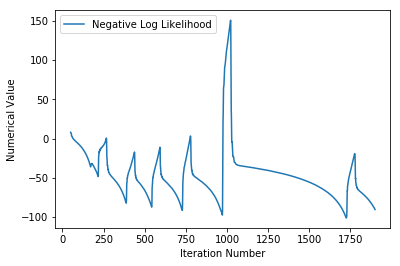

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


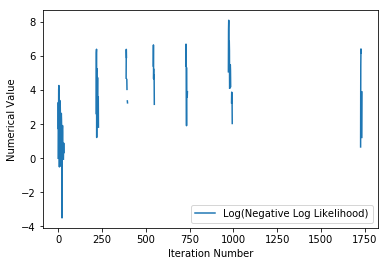

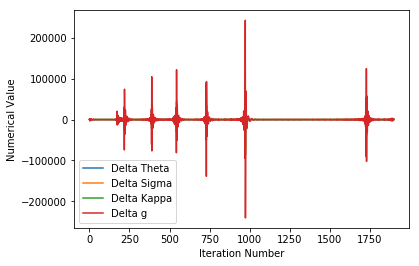

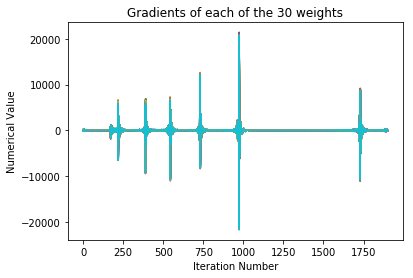

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


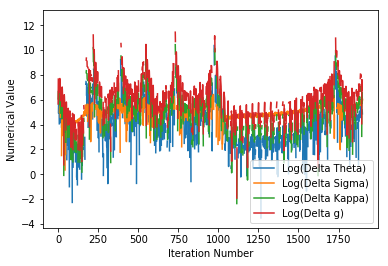

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log


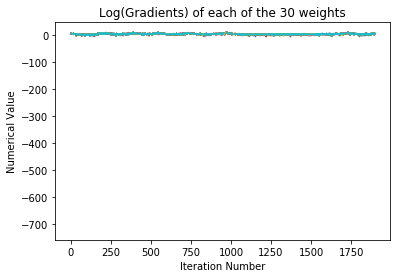

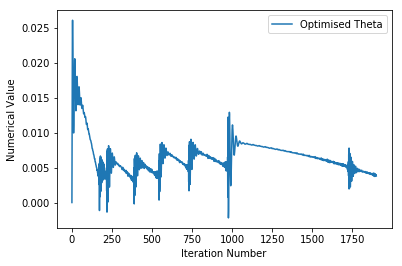

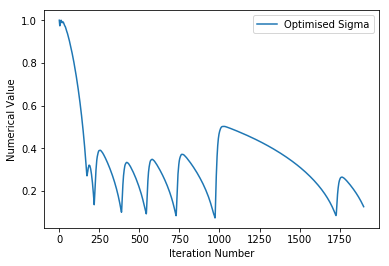

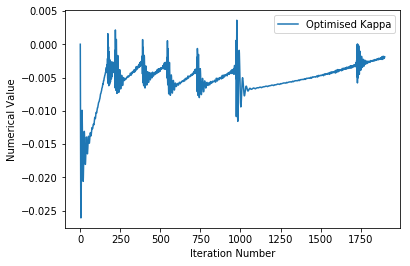

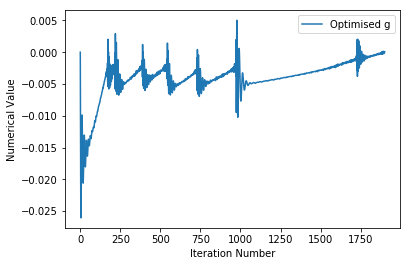

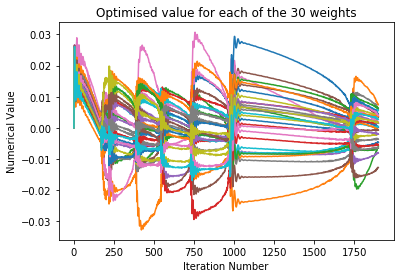

In [0]:
#####Plots for convergence
plt.plot([np.mean(errors[i-50:i]) for i in range(len(errors))], label = "Negative Log Likelihood")
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(np.log(errors), label = "Log(Negative Log Likelihood)")
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(gradients[:,0], label='Delta Theta')
plt.plot(gradients[:,1], label='Delta Sigma')
plt.plot(gradients[:,2], label='Delta Kappa')
plt.plot(gradients[:,3], label='Delta g')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(gradients_weights, label='Delta Weights')
plt.title('Gradients of each of the 30 weights')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(np.log(gradients[:,0]), label='Log(Delta Theta)')
plt.plot(np.log(gradients[:,1]), label='Log(Delta Sigma)')
plt.plot(np.log(gradients[:,2]), label='Log(Delta Kappa)')
plt.plot(np.log(gradients[:,3]), label='Log(Delta g)')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(np.log(gradients_weights), label='Log(Delta Weights)')
plt.title('Log(Gradients) of each of the 30 weights')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_theta, label='Optimised Theta')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_sigma, label='Optimised Sigma')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_kappa, label='Optimised Kappa')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_little_g, label='Optimised g')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_weights_vector, label='Optimised Weights')
plt.title('Optimised value for each of the 30 weights')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

